In [2]:
from model import ImageClassifier
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch as th
from torch.nn import functional as F
import pytorch_lightning as pl
import torchvision.transforms as transforms
from PIL import Image
import torchmetrics
from datasetHandler import ImageClassificationDataModule
from pytorch_lightning import Trainer
from pytorch_lightning import callbacks
from tqdm import tqdm

In [22]:
class Residual(pl.LightningModule):
    def __init__(self, in_channel, out_channel, use_1x1Conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)

        if use_1x1Conv:
            self.conv3 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

    def forward(self, X):
        out = F.relu(self.bn1(self.conv1(X)))
        out = self.bn2(self.conv2(out))
        if self.conv3:
            X = self.conv3(X)
        out += X
        return F.relu(out)

def residualBlock(in_channel, out_channel, num_residuals, first_block=False):
    blks = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blks.append(Residual(in_channel, out_channel, use_1x1Conv=True,
            strides=2))
        else:
            blks.append(Residual(out_channel, out_channel))
    
    return blks

class ResNet(pl.LightningModule):
    def __init__(self, input_channel, num_classes,
                ):
        super().__init__()

        #  Reproducibility
        #th.manual_seed(seed)
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        #self.b2 = nn.Sequential(*residualBlock(64, 64, 2, first_block=True))
        #self.b3 = nn.Sequential(*residualBlock(64, 128, 2))
        self.b4 = nn.Sequential(*residualBlock(64, 256, 2))
        self.b5 = nn.Sequential(*residualBlock(256, 512, 2))
        self.finalLayer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),nn.Linear(512, 1))

        self.b1.apply(self.init_weights)
        #self.b2.apply(self.init_weights)
        #self.b3.apply(self.init_weights)
        self.b4.apply(self.init_weights)
        self.b5.apply(self.init_weights)
        self.finalLayer.apply(self.init_weights)
      
     

    def init_weights(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)
        


    def forward(self, X):
        out = self.b1(X)
        #out = self.b2(out)
        #out = self.b3(out)
        out = self.b4(out)
        #out = self.dropout(out)
        out = self.b5(out)
        #out = self.dropout(out)
        out = self.finalLayer(out)
        th.cuda.empty_cache()
        return out

In [3]:
def load_image(image_path):
    image = Image.open(image_path)
    # Transforme a imagem em um tensor
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image)
    return image_tensor

In [4]:
test = pd.read_csv("../data/test.csv",index_col=0)

In [5]:
model = ImageClassifier.load_from_checkpoint("../checkpoints/best_weight_acc-v1.ckpt",input_size = (256,256), 
        kernel_size = (3,3), 
        stride_kernel_size = (1,1), 
        max_pool_size = (2,2), 
        stride_max_pool_size = (2,2),
        num_classes = 2,
        seed = 42,
        learning_rate=0.0005,
        weight_decay=0.0005,
        dropout=0.4)

In [15]:
# class ImageClassifier(pl.LightningModule):
#     def __init__(self, 
#                 input_size, 
#                 kernel_size, 
#                 stride_kernel_size, 
#                 max_pool_size, 
#                 stride_max_pool_size,
#                 num_classes,
#                 learning_rate,
#                 dropout,
#                 weight_decay,
#                 seed
#                 ):
#         super(ImageClassifier, self).__init__()

#         #  Reproducibility
#         th.manual_seed(seed)
        
#         # Architeture
#         # Conv layers
#         self.conv1 = nn.Conv2d(3, 16, kernel_size,stride_kernel_size)  # 3 channels in, 16 channels out, kernel 3x3 e stride 1
#         #self.conv2 = nn.Conv2d(8, 16, kernel_size,stride_kernel_size) # 16 channels in, 32 channels out, kernel 3x3 e stride 1
#         #self.conv3 = nn.Conv2d(16, 8, kernel_size,stride_kernel_size) # 32 channels in, 16 channels out, kernel 3x3 e stride 1

#         # Pooling
#         self.pool = nn.MaxPool2d((2,2), 2) # Kernel size 2 x 2 stride 1
        
#         # Flatten size calculation

#         #Convolution layer 1
#         hconv1 =int((input_size[0] - kernel_size[0] + stride_kernel_size[0]) / stride_kernel_size[0])
#         wconv1 =int((input_size[1] - kernel_size[1] + stride_kernel_size[1]) / stride_kernel_size[1])

#         hmaxpool = int((hconv1 - max_pool_size[0] + stride_max_pool_size[0]) / stride_max_pool_size[0])
#         wmaxpool = int((wconv1 - max_pool_size[1] + stride_max_pool_size[1]) / stride_max_pool_size[1])

#         # #Convolution layer 2
#         # hconv2 =int((hmaxpool - kernel_size[0] + stride_kernel_size[0]) / stride_kernel_size[0])
#         # wconv2 =int((wmaxpool - kernel_size[1] + stride_kernel_size[1]) / stride_kernel_size[1])

#         # hmaxpool =int((hconv2 - max_pool_size[0] + stride_max_pool_size[0]) / stride_max_pool_size[0])
#         # wmaxpool =int((wconv2 - max_pool_size[1] + stride_max_pool_size[1]) / stride_max_pool_size[1])

#         # #Convolution layer 3
#         # hconv3 =int((hmaxpool - kernel_size[0] + stride_kernel_size[0]) / stride_kernel_size[0])
#         # wconv3 =int((wmaxpool - kernel_size[1] + stride_kernel_size[1]) / stride_kernel_size[1])

#         # hmaxpool =int((hconv3 - max_pool_size[0] + stride_max_pool_size[0]) / stride_max_pool_size[0])
#         # wmaxpool =int((wconv3 - max_pool_size[1] + stride_max_pool_size[1]) / stride_max_pool_size[1])
                
#         flat_size = 16 * hmaxpool * wmaxpool
        
#         # Dense Layers
#         self.dense1 = nn.Linear(flat_size, 32)
#         self.dense2 = nn.Linear(32, 1) 


#     def forward(self , x):
#             x = self.pool(F.relu(self.conv1(x)))
#             #x = self.pool(F.relu(self.conv2(x)))
          
#         #x = self.pool(F.relu(self.conv3(x)))
        
#             x = x.view(x.size(0), -1)
#             x = F.relu(self.dense1(x))
#             x = F.sigmoid(self.dense2(x))

#             return x

In [11]:
y_gts = []
y_hats = []
for idx, row in tqdm(test.iterrows(), total=test.shape[0]):
    x = load_image("../"+ row["path"])
    x = x.unsqueeze(0)
    y_gts.append(row["label"])
    result = th.tensor(model(x.to("cuda")).item())
    y_hats.append(result)
    
y_hats = [1 if y_hat > 0.5 else 0 for y_hat in y_hats]
    

100%|██████████| 30/30 [00:00<00:00, 91.15it/s]


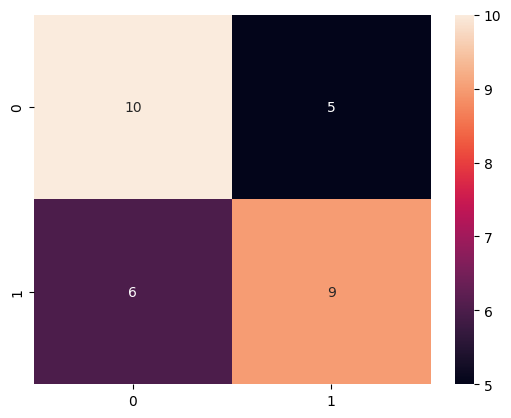

Acurácia:  0.6333333333333333
Precisão:  0.6428571428571429
Recall:  0.6
F1:  0.6206896551724138


In [14]:
# criar matriz de confusão

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_gts, y_hats)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# calcular acurácia
from sklearn.metrics import accuracy_score

# calcular precisão
from sklearn.metrics import precision_score


# calcular recall
from sklearn.metrics import recall_score


# calcular f1
from sklearn.metrics import f1_score


print("Acurácia: ", accuracy_score(y_gts, y_hats))
print("Precisão: ", precision_score(y_gts, y_hats))
print("Recall: ", recall_score(y_gts, y_hats))
print("F1: ", f1_score(y_gts, y_hats))